# Modeling Workflow

In [29]:
# %load /Users/andrew.lofgreen/data-science-scripts/andyl/notebook_setup.py
%matplotlib inline
import datarobot as dr
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import random
import itertools
import time
from IPython.core.display import display, HTML
import pprint as pp
from hyperopt import hp, tpe, fmin
sys.path.insert(1, '/Users/andrew.lofgreen/data-science-scripts/andyl/')
import dr_utils
display(HTML('<style>.container {width:90% !important;}</style>'))

In [2]:
#start session
dr.Client()

## Setup

In [37]:
#setup project
project_name = "Manual Modeling Workflow"
url = 'https://s3.amazonaws.com/datarobot_public_datasets/DR_Demo_LendingClub_Guardrails.csv'
project = dr.Project.create(url, project_name=project_name)
print('Project ID: {}'.format(project.id))

Project ID: 62c5f0fb1692a2d5932222d6


In [38]:
## START THE PROJECT BUT NO MODELING YET (there are other functions to start a project as well)

## advanced options object if needed
advanced_options = dr.AdvancedOptions(accuracy_optimized_mb=True,
                                      consider_blenders_in_recommendation=False,
                                      shap_only_mode=True,
                                      blend_best_models=False)

## set partition method: in this case setting it as TVH with statified random sampling
partition_method = dr.StratifiedTVH(holdout_pct=20, validation_pct=20)

project.set_target('is_bad',
                   mode = 'manual', 
                   worker_count = -1, 
                   partitioning_method = partition_method, 
                   advanced_options = advanced_options)

Project(Manual Modeling Workflow)

In [39]:
## SELECT BLUEPRINTS TO RUN

#Get the blueprints
blueprints = project.get_blueprints()

# blueprints

In [40]:
#Now that we have the Blueprints, we can search for a specific blueprint. 
#For example all models that have "Gradient" in their name

model_type = "Elastic"

models_to_run = []
for blueprint in blueprints:
    if model_type in blueprint.model_type:
        models_to_run.append(blueprint)

models_to_run

[Blueprint(Light Gradient Boosting on ElasticNet Predictions ),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance) with Binned numeric features),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L1 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (L2 / Binomial Deviance)),
 Blueprint(Elastic-Net Classifier (mixing alpha=0.5 / Binomial Deviance))]

In [8]:
## SELECT FEATURE LISTS
for fl in project.get_featurelists():
    print("featurue list:", fl, "ID:", fl.id)

featurue list: Featurelist(Raw Features) ID: 62bcc8c8f77a3aee95a3db93
featurue list: Featurelist(Informative Features) ID: 62bcc8c8f77a3aee95a3db97
featurue list: Featurelist(Informative Features - Leakage Removed) ID: 62bcc903622056920d30d86e
featurue list: Featurelist(Univariate Selections) ID: 62bcc903622056920d30d872
featurue list: Featurelist(DR Association Reduced Features) ID: 62bcc90ea4e7e9bc6bfd4a1c


#### Start Modeling

In [9]:
## Kick off each of the blueprints with a feature list that has no collinearity:DR Association Reduced Features
for model in models_to_run:
    project.train(model, sample_pct = 80, featurelist_id='62bcc903622056920d30d86e')

In [10]:
## look at the leaderboard with multiple metrics
models = project.get_models()
scores = pd.DataFrame([{'model_obj': model,
                        'model_type': model.model_type,
                        'model_id': model.id,
                        'sample_pct': model.sample_pct,
                        'featurelist': model.featurelist_id,
                        'val_logloss': model.metrics['LogLoss']['validation'],
                        'val_AUC': model.metrics['AUC']['validation'],
                        'val_RMSE': model.metrics['RMSE']['validation']}
                        for model in models])
scores.head(10)

,model_obj,model_type,model_id,sample_pct,featurelist,val_logloss,val_AUC,val_RMSE
0,Model('Elastic-Net Classifier (L2 / Binomial D...,Elastic-Net Classifier (L2 / Binomial Deviance),62bdcabddcd7cc2edeeab907,80.0,62bcc903622056920d30d86e,0.37499,0.62391,0.33243
1,Model('Light Gradient Boosting on ElasticNet P...,Light Gradient Boosting on ElasticNet Predicti...,62bdcab4653763047a6a76c5,80.0,62bcc903622056920d30d86e,0.37630,0.62449,0.33344
2,Model('Elastic-Net Classifier (L2 / Binomial D...,Elastic-Net Classifier (L2 / Binomial Deviance),62bdcab9653763047a6a76ef,80.0,62bcc903622056920d30d86e,0.37634,0.61711,0.33304
3,Model('Elastic-Net Classifier (L2 / Binomial D...,Elastic-Net Classifier (L2 / Binomial Deviance),62bdcabbbe63fec143eab998,80.0,62bcc903622056920d30d86e,0.37634,0.61711,0.33304
4,Model('Elastic-Net Classifier (L2 / Binomial D...,Elastic-Net Classifier (L2 / Binomial Deviance),62bdcab5dcd7cc2edeeab8d9,80.0,62bcc903622056920d30d86e,0.37672,0.61078,0.33311
5,Model('Elastic-Net Classifier (L1 / Binomial D...,Elastic-Net Classifier (L1 / Binomial Deviance),62bdcabd653763047a6a7732,80.0,62bcc903622056920d30d86e,0.37717,0.61264,0.33324
6,Model('Elastic-Net Classifier (mixing alpha=0....,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,62bdcab7653763047a6a76df,80.0,62bcc903622056920d30d86e,0.37722,0.61138,0.33316
7,Model('Elastic-Net Classifier (mixing alpha=0....,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,62bdcabcb15fbcd2203f3f5c,80.0,62bcc903622056920d30d86e,0.37738,0.60774,0.33337
8,Model('Elastic-Net Classifier (mixing alpha=0....,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,62bdcabe9418fbf1683f3f77,80.0,62bcc903622056920d30d86e,0.37738,0.60774,0.33337
9,Model('Elastic-Net Classifier (mixing alpha=0....,Elastic-Net Classifier (mixing alpha=0.5 / Bin...,62bdcabbdcd7cc2edeeab8f7,80.0,62bcc903622056920d30d86e,0.37760,0.60581,0.33342


In [12]:
#Get Feature Impact
m = models[0]
feature_impact = m.get_or_request_feature_impact()

#Save feature impact in pandas dataframe
fi_df = pd.DataFrame(feature_impact)

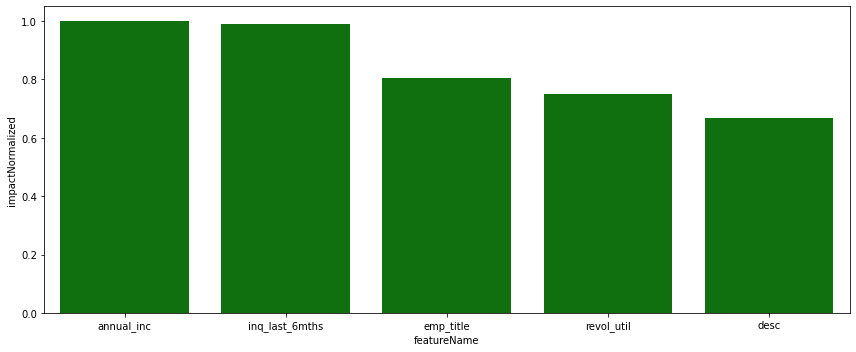

In [13]:
## plot feature impact
fig, ax = plt.subplots(figsize = (12,5))

#Plot feature impact
sns.barplot(x='featureName', y='impactNormalized', data=fi_df[0:5], color='g')

plt.tight_layout()

### Common strategies for hyperparameter tuning

There are four common strategies for hyperparameter tuning. Best practice will depend on the needs of the project, the size of the dataset, the algorithms being used, and availability of domain expertise.

1. Manual
2. Grid search
3. Random
4. Optimized

In [14]:
#First, set up an advanced tuning session
model_to_tune = m
tune = model_to_tune.start_advanced_tuning_session()
param_details = model_to_tune.get_advanced_tuning_parameters()["tuning_parameters"]
param_list = [x["parameter_name"] for x in param_details] #see list of tuned parameters

#View the different tasks available for tuning - in this case, the model itself plus pre-processing parameters and missing value imputation
tasks = tune.get_task_names()
for task in tasks:
    pp.pprint (task)
    pp.pprint (tune.get_parameter_names(task))
    print()

'Elastic-Net Classifier (L2 / Binomial Deviance)'
['enet_alpha',
 'enet_lambda',
 'fit_alpha_scaler',
 'fit_intercept',
 'max_iter',
 'random_state',
 'sigma',
 'tol']

'Matrix of word-grams occurrences'
['analyzer',
 'binary',
 'language',
 'lowercase',
 'max_df',
 'max_features',
 'max_ngram',
 'min_df',
 'min_ngram',
 'norm',
 'pos_tagging',
 'smooth_idf',
 'stemmer',
 'stop_words',
 'sublinear_tf',
 'tokenizer',
 'use_idf']

'One-Hot Encoding'
['max_features', 'min_support']



In [15]:
param_details = model_to_tune.get_advanced_tuning_parameters()["tuning_parameters"]
param_list = [x["parameter_name"] for x in param_details] #see list of tuned parameters
param_details

[{'parameter_name': 'enet_alpha',
  'parameter_id': 'eyJhcmciOiJlbmV0X2FscGhhIiwidmlkIjoiNiJ9',
  'default_value': 0,
  'current_value': 0,
  'task_name': 'Elastic-Net Classifier (L2 / Binomial Deviance)',
  'constraints': {'select': {'values': ['auto']},
   'float': {'min': 0, 'max': 1, 'supports_grid_search': True}}},
 {'parameter_name': 'enet_lambda',
  'parameter_id': 'eyJhcmciOiJlbmV0X2xhbWJkYSIsInZpZCI6IjYifQ',
  'default_value': 0.0188586328,
  'current_value': 0.0188586328,
  'task_name': 'Elastic-Net Classifier (L2 / Binomial Deviance)',
  'constraints': {'select': {'values': ['auto']},
   'float': {'min': 1e-10,
    'max': 0.9999999999,
    'supports_grid_search': True}}},
 {'parameter_name': 'fit_alpha_scaler',
  'parameter_id': 'eyJhcmciOiJmaXRfYWxwaGFfc2NhbGVyIiwidmlkIjoiNiJ9',
  'default_value': 'True',
  'current_value': 'True',
  'task_name': 'Elastic-Net Classifier (L2 / Binomial Deviance)',
  'constraints': {'select': {'values': ['False', 'True']}}},
 {'parameter_name

In [16]:
#Specify variables to tune - I'm choosing three and filling up the grid space with reasonable values for these parameters
param_grid = {
        "enet_alpha": [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        "enet_lambda": [0.001, 0.002, 0.003, 0.004, 0.005, 0.0075,
                        0.01, 0.02, 0.03, 0.04, 0.05, 0.075,
                        0.1, 0.2, 0.3, 0.4, 0.5, 0.75],
        "max_ngram": [1,2,3,4,5]}
parameters_to_tune = list(param_grid.keys())

param_index = [param_list.index(x) for x in parameters_to_tune]
param_ids = [param_details[x]["parameter_id"] for x in param_index] #each parameter has a unique ID, which we need to pull out
keys, values = zip(*param_grid.items())

#View the appropriate constraints
for var in parameters_to_tune:
    print(var)
    pp.pprint (param_details[param_list.index(var)])
    print()

enet_alpha
{'constraints': {'float': {'max': 1, 'min': 0, 'supports_grid_search': True},
                 'select': {'values': ['auto']}},
 'current_value': 0,
 'default_value': 0,
 'parameter_id': 'eyJhcmciOiJlbmV0X2FscGhhIiwidmlkIjoiNiJ9',
 'parameter_name': 'enet_alpha',
 'task_name': 'Elastic-Net Classifier (L2 / Binomial Deviance)'}

enet_lambda
{'constraints': {'float': {'max': 0.9999999999,
                           'min': 1e-10,
                           'supports_grid_search': True},
                 'select': {'values': ['auto']}},
 'current_value': 0.0188586328,
 'default_value': 0.0188586328,
 'parameter_id': 'eyJhcmciOiJlbmV0X2xhbWJkYSIsInZpZCI6IjYifQ',
 'parameter_name': 'enet_lambda',
 'task_name': 'Elastic-Net Classifier (L2 / Binomial Deviance)'}

max_ngram
{'constraints': {'int': {'max': 99, 'min': 0, 'supports_grid_search': False}},
 'current_value': 2,
 'default_value': 2,
 'parameter_id': 'eyJhcmciOiJtYXhfbmdyYW0iLCJ2aWQiOiI1In0',
 'parameter_name': 'max_ngram',


In [17]:
random_proportion = 0.05
random.seed(645) #Setting random seed for reproducibility
queue = []
parameter_queue = []

In [18]:
for v in itertools.product(*values):
    
    if random.random() < random_proportion:
          
        #set hyperparameters - maybe a better way of doing this?
        random_dict = dict(zip(param_ids, list(v)))
        
        try:
            random_job = model_to_tune.advanced_tune(random_dict)
        
        #DR will throw an error if we try and run a model with hyperparameters we've already used, which can happen
        #In this case, we know that we've picked the best model of the models of this type that we generated,
        #so we can go ahead and skip those
        except: 
            continue
        
        queue.append(random_job)
        parameter_queue.append(random_dict.values())

In [19]:
jobs_list = project.get_all_jobs() #This is the queue with jobs running
jobs_list

[Job(model, status=inprogress)]

In [20]:
col_names = ['validation','trial']
grid_results = pd.DataFrame(columns = col_names + list(keys))

#Now get the results from each of the ModelJobs in the queue
for i in range(len(queue)):
    completed_model = queue[i].get_result_when_complete()
            
    eval_results = [completed_model.metrics[project.metric]["validation"],
                    i] + list(parameter_queue[i])
                
    grid_results.loc[i, :] = eval_results

In [21]:
#For speed, we're comparing on a single validation set here. You could also have DR run cross-validation for these
#models and compare them that way
grid_results = grid_results.sort_values("validation")
grid_results.head(10)

,validation,trial,enet_alpha,enet_lambda,max_ngram
5,0.37483,5,0.0,0.03,2
4,0.37505,4,0.0,0.02,3
38,0.37509,38,0.6,0.02,4
39,0.3751,39,0.6,0.02,5
34,0.37511,34,0.5,0.04,4
33,0.37518,33,0.5,0.02,2
14,0.3752,14,0.2,0.04,3
29,0.37525,29,0.4,0.03,3
32,0.37531,32,0.5,0.02,1
47,0.37532,47,0.8,0.04,5


#### Optimization

In [30]:
#Set up an advanced tuning session
tune = model_to_tune.start_advanced_tuning_session()
param_details = model_to_tune.get_advanced_tuning_parameters()["tuning_parameters"]
param_list = [x["parameter_name"] for x in param_details] #see list of tuned parameters

#View the different tasks available for tuning - in this case, the model itself plus pre-processing parameters and missing value imputation
tasks = tune.get_task_names()
for task in tasks:
    pp.pprint (task)
    pp.pprint (tune.get_parameter_names(task))
    print()

'Elastic-Net Classifier (L2 / Binomial Deviance)'
['enet_alpha',
 'enet_lambda',
 'fit_alpha_scaler',
 'fit_intercept',
 'max_iter',
 'random_state',
 'sigma',
 'tol']

'Matrix of word-grams occurrences'
['analyzer',
 'binary',
 'language',
 'lowercase',
 'max_df',
 'max_features',
 'max_ngram',
 'min_df',
 'min_ngram',
 'norm',
 'pos_tagging',
 'smooth_idf',
 'stemmer',
 'stop_words',
 'sublinear_tf',
 'tokenizer',
 'use_idf']

'One-Hot Encoding'
['max_features', 'min_support']



In [31]:
parameters_to_tune = ["enet_alpha", "enet_lambda"]
param_index = [param_list.index(x) for x in parameters_to_tune]
param_ids = [param_details[x]["parameter_id"] for x in param_index]

In [32]:
space = [hp.choice('enet_alpha',[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
         hp.choice('enet_lambda',[0.001, 0.002, 0.003, 0.004, 0.005, 
                                0.0075,0.01, 0.02, 0.03, 0.04, 0.05, 0.075,
                                0.1, 0.2, 0.3, 0.4, 0.5, 0.75])]

In [33]:
def function(args): 
    arg1, arg2 = args #these are the parameters we defined in space above (in this example, n_layers and optimizer)

    opt_dict = dict(zip(param_ids, args))
    
    print ("enet_alpha: %d" % (arg1))
    print ("enet_labda: %s" % (arg2))

    optimize_job = model_to_tune.advanced_tune(opt_dict)
    
    #while the model is still running, don't proceed
    while(len(project.get_all_jobs())>0):
        time.sleep(5)
    
    finished_model = optimize_job.get_result_when_complete()
    
    #note that we're using validation here for speed, but you could also have DR run crossvalidation for each of these 
    #models and compare that
    validation_performance = finished_model.metrics[project.metric]["validation"] 
    
    loss = validation_performance
    print("loss: %1.4f" % loss)
    
    return (loss)

In [35]:
best = fmin(function, space, algo=tpe.suggest, max_evals=8)

In [14]:
## kick off some neural network models
for model in models_to_run:
    project.train(model, sample_pct = 80, featurelist_id='62b526d301045e1a3c45cae7')

### Inference with .jar model export

In [127]:
d = dr.Deployment.create_from_learning_model(m.id, label = 'Modeling_Workflow_Deployment_codeDeploy2', default_prediction_server_id='5a61d7a0fbd723001a2f70d9')d

In [130]:
## CAN DOWNLOAD SCORING CODE VIA API BUT GETTING THE PREDICTION EXPLANATIONS ENABLED REQUIERS THE UI
d.download_scoring_code(filepath = 'scoring_code_api_download.jar', include_agent=True)

### Score

#### With .jar output

In [147]:
!java -Dlog4j2.formatMsgNoLookups=true -jar scoring_code_cash_offer.jar csv --input=/Users/andrew.lofgreen/Documents/Demo/Datasets/DR_Demo_LendingClub_Guardrails_Fairness.csv --output=output_predictions_jar.csv --with_explanations=yes --max_codes=3

15:03:48.869 [main] INFO application - Starting processing data with params:
15:03:48.871 [main] INFO application - model_id: 62b3e4e33d0162101c67254b;
15:03:48.871 [main] INFO application - input: /Users/andrew.lofgreen/Documents/Demo/Datasets/DR_Demo_LendingClub_Guardrails_Fairness.csv;
15:03:48.872 [main] INFO application - output: output_predictions_jar.csv;
15:03:48.872 [main] INFO application - encoding: UTF-8;
15:03:48.872 [main] INFO application - delimiter: null;
15:03:48.872 [main] INFO application - passthrough_columns: [];
15:03:48.872 [main] INFO application - chunk_size: 150;
15:03:48.872 [main] INFO application - workers_number: 4;
15:03:48.872 [main] INFO application - log_level: INFO;
15:03:48.872 [main] INFO application - fail_fast: false;
15:03:48.872 [main] INFO application - pred_name: PREDICTION;
15:03:48.872 [main] INFO application - timeout: 1000;
15:03:48.873 [main] INFO application - buffer_size: 1000;
15:03:48.873 [main] INFO application - config: .;
15:03:48

In [ ]:
#Scoring With Prediction Explanations

# dr.BatchPredictionJob.score(
#     '62b3e97530c2dca410b6c455',
#     intake_settings={
#         'type': 'localFile',
#         'file': '/Users/andrew.lofgreen/Documents/Demo/Datasets/DR_Demo_LendingClub_Guardrails_Fairness.csv' #Path or Pandas or file-like object
#     },
#     output_settings={
#         'type': 'localFile',
#         'path': '/Users/andrew.lofgreen/Documents/Customers/WF/output_predictions.csv'
#     },
    
#     max_explanations=3 #Compute prediction explanations for this amount of features
    
# )

In [ ]:
# !python predict.py /Users/andrew.lofgreen/Documents/Demo/Datasets/DR_Demo_LendingClub_Guardrails_Fairness.csv output_predictions_predict_script.csv